In [173]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import time
import math
import os
from collections import Counter

In [174]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bestwater/wikitext-2-v1")

print("Path to dataset files:", path)

Path to dataset files: /home/ben/.cache/kagglehub/datasets/bestwater/wikitext-2-v1/versions/1


**THEN MOVE THE FILE DIRECTORY TO THIS DIRECTORY**

In [175]:
import os

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

# Set random seeds for reproducibility
random.seed(2)
np.random.seed(2)
torch.manual_seed(2)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [176]:
# WikiText2 corpus paths
corpus_path = './wikitext-2'
train_path = os.path.join(corpus_path, 'wiki.train.tokens')
valid_path = os.path.join(corpus_path, 'wiki.valid.tokens')
test_path = os.path.join(corpus_path, 'wiki.test.tokens')

In [177]:
# Hyperparameters
embed_dim = 100
hidden_dim = 256
dropout_prob = 0.5
num_epochs = 20
batch_size = 32
seq_length = 29  # Number of unrolled time steps
learning_rate = 0.001
vocab_size = 10000  # Reduced vocabulary size
unk_threshold = 5  # Frequency threshold for unknown tokens

In [178]:
def read_corpus(path):
    """Read corpus file and return list of whitespace-tokenized words"""
    with open(path, 'r', encoding='utf-8') as f:
        text = f.read().replace('\n', ' <eos> ')
    return text.split(' ')

def build_vocab(tokens, threshold=unk_threshold):
    """Build vocabulary from tokens with frequency threshold"""
    counter = Counter(tokens)
    # Sort tokens by frequency (descending)
    sorted_tokens = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    
    # Create vocabulary: reserve 0 for padding, 1 for <unk>
    vocab = {'<pad>': 0, '<unk>': 1, '<eos>': 2}
    idx = 3
    
    # Add tokens that appear more than threshold times
    for token, count in sorted_tokens:
        if count >= threshold and idx < vocab_size:
            if token and token != '<eos>':  # Skip empty tokens and already added special tokens
                vocab[token] = idx
                idx += 1
        if idx >= vocab_size:
            break
    
    return vocab

def tokens_to_indices(tokens, vocab):
    """Convert tokens to indices using vocabulary"""
    return [vocab.get(token, vocab['<unk>']) for token in tokens if token]

def batchify(data, bsz):
    """Divide dataset into batches and arrange for back-propagation through time"""
    # Work out how cleanly we can divide the dataset into bsz parts
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit
    data = data[:nbatch * bsz]
    # Evenly divide the data across the bsz batches
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

def get_batch(source, i, seq_length):
    """Get a batch for training"""
    seq_len = min(seq_length, source.size(0) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [179]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout_prob):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=False, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.decoder = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim
        self.init_weights()
        
    def init_weights(self):
        """Initialize weights for better training"""
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
        
    def init_hidden(self, batch_size):
        """Initialize hidden state"""
        return torch.zeros(1, batch_size, self.hidden_dim).to(device)
        
    def forward(self, x, hidden):
        """Forward pass"""
        # x shape: (seq_len, batch_size)
        emb = self.dropout(self.embedding(x))  # (seq_len, batch_size, embed_dim)
        output, hidden = self.rnn(emb, hidden)  # output: (seq_len, batch_size, hidden_dim)
        output = self.dropout(output)
        decoded = self.decoder(output.view(-1, self.hidden_dim))  # (seq_len*batch_size, vocab_size)
        return decoded, hidden


In [180]:
def train(model, train_data, criterion, optimizer, seq_length):
    """Train model for one epoch"""
    model.train()
    total_loss = 0.
    start_time = time.time()
    hidden = model.init_hidden(batch_size)
    
    # Get total number of batches
    num_batches = (train_data.size(0) - 1) // seq_length
    
    for batch, i in enumerate(range(0, train_data.size(0) - 1, seq_length)):
        # Skip if we'd go out of bounds
        if i > train_data.size(0) - 2:
            continue
            
        data, targets = get_batch(train_data, i, seq_length)
        
        # Initialize hidden state for new batch
        hidden = hidden.detach()
        
        # Forward pass
        output, hidden = model(data, hidden)
        loss = criterion(output, targets)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch % 50 == 0 and batch > 0:
            cur_loss = total_loss / 50
            elapsed = time.time() - start_time
            print(f'| epoch {epoch:3d} | batch {batch:5d}/{num_batches:5d} | '
                  f'ms/batch {elapsed * 1000 / 50:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {math.exp(cur_loss):8.2f}')
            total_loss = 0
            start_time = time.time()
    
def evaluate(model, eval_data, criterion, seq_length):
    """Evaluate the model"""
    model.eval()
    total_loss = 0.
    hidden = model.init_hidden(batch_size)
    num_tokens = 0
    
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, seq_length):
            # Skip if we'd go out of bounds
            if i > eval_data.size(0) - 2:
                continue
                
            data, targets = get_batch(eval_data, i, seq_length)
            hidden = hidden.detach()
            output, hidden = model(data, hidden)
            
            loss = criterion(output, targets)
            total_loss += loss.item() * targets.size(0)
            num_tokens += targets.size(0)
    
    # Calculate perplexity
    avg_loss = total_loss / num_tokens if num_tokens > 0 else float('inf')
    perplexity = math.exp(avg_loss)
    return perplexity

In [181]:
try:
    # Load and preprocess data
    print("Loading and preprocessing corpus...")
    train_tokens = read_corpus(train_path)
    valid_tokens = read_corpus(valid_path)
    test_tokens = read_corpus(test_path)

    # Build vocabulary from training tokens
    vocab = build_vocab(train_tokens)
    print(f"Vocabulary size: {len(vocab)}")

    # Convert tokens to indices
    train_indices = tokens_to_indices(train_tokens, vocab)
    valid_indices = tokens_to_indices(valid_tokens, vocab)
    test_indices = tokens_to_indices(test_tokens, vocab)

    # Safety check: ensure all indices are valid
    max_idx = max(train_indices + valid_indices + test_indices)
    if max_idx >= len(vocab):
        print(f"Warning: Found index {max_idx} but vocab size is {len(vocab)}")
        print("Fixing indices...")
        train_indices = [min(idx, len(vocab) - 1) for idx in train_indices]
        valid_indices = [min(idx, len(vocab) - 1) for idx in valid_indices]
        test_indices = [min(idx, len(vocab) - 1) for idx in test_indices]

    # Convert to tensors and batchify - use CPU first for safety
    train_data = batchify(torch.tensor(train_indices, dtype=torch.long), batch_size)
    valid_data = batchify(torch.tensor(valid_indices, dtype=torch.long), batch_size)
    test_data = batchify(torch.tensor(test_indices, dtype=torch.long), batch_size)

    # Initialize model
    model = RNNModel(len(vocab), embed_dim, hidden_dim, dropout_prob).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
except Exception as e:
    import traceback
    print(f"An error occurred: {e}")
    traceback.print_exc()

Loading and preprocessing corpus...
Vocabulary size: 9999
Fixing indices...


In [182]:
# Training loop
try:
    best_val_ppl = float('inf')
    print("Starting training...")

    val_ppls = []
    train_ppls = []


    
    for epoch in range(1, num_epochs + 1):
        epoch_start_time = time.time()
        train(model, train_data, criterion, optimizer, seq_length)
        val_ppl = evaluate(model, valid_data, criterion, seq_length)
        train_ppl = evaluate(model, train_data, criterion, seq_length)

        val_ppls.append(val_ppl)
        train_ppls.append(train_ppl)
        
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {(time.time() - epoch_start_time):5.2f}s | '
              f'valid ppl {val_ppl:8.2f}')
        print('-' * 89)
        
        # Save the model if validation performance improves
        if val_ppl < best_val_ppl:
            best_val_ppl = val_ppl
            torch.save(model.state_dict(), 'best_rnn_model.pth')
            print(f"New best model saved with perplexity: {val_ppl:8.2f}")

    # Load best model and evaluate on test set
    try:
        model.load_state_dict(torch.load('best_rnn_model.pth'))
        test_ppl = evaluate(model, test_data, criterion, seq_length)
        print('=' * 89)
        print(f'| End of training | test ppl {test_ppl:8.2f}')
        print('=' * 89)
    except Exception as e:
        print(f"Error loading best model: {e}")
        print("Evaluating with current model instead.")
        test_ppl = evaluate(model, test_data, criterion, seq_length)
        print('=' * 89)
        print(f'| End of training | test ppl {test_ppl:8.2f}')
        print('=' * 89)

except Exception as e:
    import traceback
    print(f"An error occurred: {e}")
    traceback.print_exc()

Starting training...
| epoch   1 | batch    50/ 2250 | ms/batch  5.32 | loss  7.18 | ppl  1312.70
| epoch   1 | batch   100/ 2250 | ms/batch  4.73 | loss  6.37 | ppl   582.17
| epoch   1 | batch   150/ 2250 | ms/batch  4.77 | loss  6.14 | ppl   466.26
| epoch   1 | batch   200/ 2250 | ms/batch  4.73 | loss  5.99 | ppl   399.39
| epoch   1 | batch   250/ 2250 | ms/batch  4.72 | loss  5.95 | ppl   384.58
| epoch   1 | batch   300/ 2250 | ms/batch  4.72 | loss  5.95 | ppl   383.56
| epoch   1 | batch   350/ 2250 | ms/batch  4.74 | loss  5.83 | ppl   341.99
| epoch   1 | batch   400/ 2250 | ms/batch  4.72 | loss  5.80 | ppl   329.88
| epoch   1 | batch   450/ 2250 | ms/batch  4.71 | loss  5.72 | ppl   303.80
| epoch   1 | batch   500/ 2250 | ms/batch  4.71 | loss  5.69 | ppl   295.95
| epoch   1 | batch   550/ 2250 | ms/batch  4.71 | loss  5.63 | ppl   277.63
| epoch   1 | batch   600/ 2250 | ms/batch  4.71 | loss  5.60 | ppl   269.09
| epoch   1 | batch   650/ 2250 | ms/batch  4.73 | loss

In [186]:
# Function to generate text
def generate_text(model, vocab, seed_text="the", max_length=50):
    """Generate text using the trained model"""
    model.eval()
    
    # Create reverse vocab (index to token)
    idx_to_token = {idx: token for token, idx in vocab.items()}
    
    # Convert seed text to tensor
    if seed_text in vocab:
        input_idx = vocab[seed_text]
    else:
        input_idx = vocab['<unk>']
    
    input_tensor = torch.tensor([[input_idx]], device=device)
    hidden = model.init_hidden(1)
    
    generated_tokens = [seed_text]
    
    with torch.no_grad():
        for _ in range(max_length):
            output, hidden = model(input_tensor, hidden)
            
            # Sample from the output distribution
            probs = torch.softmax(output, dim=1)
            next_token_idx = torch.multinomial(probs, 1).item()
            
            # Add generated token to output
            generated_tokens.append(idx_to_token.get(next_token_idx, '<unk>'))
            
            # Update input for next iteration
            input_tensor = torch.tensor([[next_token_idx]], device=device)
    
    return ' '.join(generated_tokens)

# Generate and print some text
print("\nGenerated Text Sample:")
print(generate_text(model, vocab, seed_text="The", max_length=50))


Generated Text Sample:
The game was considered a influenced potential to celebrate the night of all decade , and a hotel failures saw it came in <unk> . <unk> education the Union will break the Next Level " , hair , her old of <unk> a , fourth up of <unk> one of the


## Question 1

### a. provide a description (or illustration) of you architecture and discuss design choices

The model is a simple recurrent neural network for language modeling. It consists of:

1. **Embedding Layer (`nn.Embedding`)**  
   - Converts token indices into dense vectors of size `embed_dim`.  

2. **Recurrent Layer (`nn.RNN`)**  
   - Processes embeddings sequentially to capture temporal dependencies.  

3. **Dropout Layer (`nn.Dropout`)**  
   - Regularizes the model to prevent overfitting.  

4. **Fully Connected Layer (`nn.Linear`)**  
   - Maps hidden states to vocabulary logits for next-word prediction.  

## Design Choices
- **Vanilla RNN**: Simple but may struggle with long-term dependencies.  
- **Dropout**: Improves generalization.  
- **Embedding Layer**: Captures word relationships efficiently.  

### b. List hyper-parameters used by you model an discuss how you selected these values,

## Hyperparameters

```python
embed_dim = 100        # Word embedding size
hidden_dim = 256       # RNN hidden state size
dropout_prob = 0.5     # Dropout rate for regularization
num_epochs = 20        # Number of training iterations
batch_size = 32        # Number of samples per batch
seq_length = 29        # Number of unrolled time steps
learning_rate = 0.001  # Step size for optimization
vocab_size = 10000     # Reduced vocabulary size
unk_threshold = 5      # Frequency threshold for unknown tokens


## Selection Rationale

- **`embed_dim = 100`**  
  Balances computational efficiency and embedding quality.  

- **`hidden_dim = 256`**  
  Provides sufficient capacity without excessive overfitting.  

- **`dropout_prob = 0.5`**  
  Helps prevent overfitting by randomly dropping units.  

- **`num_epochs = 20`**  
  Predetermined by the assignment.  

- **`batch_size = 32`**  
  Standard size for stable and efficient training, tuned through trial and error.  

- **`seq_length = 29`**  
  Determines the number of unrolled time steps for training, optimized through trial and error.  

- **`learning_rate = 0.001`**  
  Common choice for stable Adam optimizer training.  

- **`vocab_size = 10000`**  
  Limits vocabulary to frequent words, reducing model complexity.  

- **`unk_threshold = 5`**  
  Filters rare words to improve generalization and efficiency.  


### c.Provide learning curves of perplexity vs. epoch on the training and validation sets

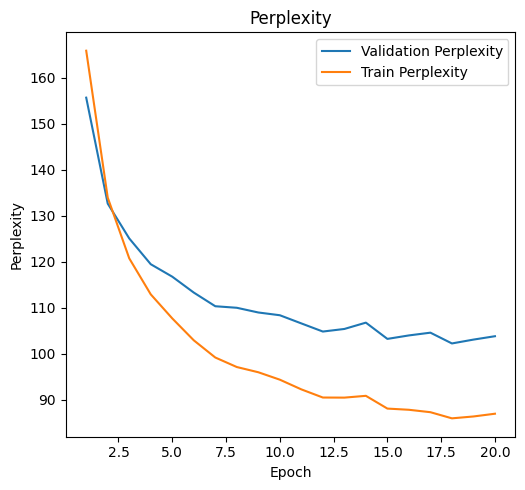

In [187]:
    # Plot learning curves
    plt.figure(figsize=(10, 5))

    # Plot Validation and Train Perplexity
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), val_ppls, label='Validation Perplexity')
    plt.plot(range(1, num_epochs + 1), train_ppls, label='Train Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Perplexity')
    plt.legend()

    plt.tight_layout()
    plt.show()

### d. Provide final test set perplexity. 

In [190]:
print(f"Final test perplexity : {test_ppl:.3f}")

Final test perplexity : 93.632


## Question 2

Discuss how you might improve this “vanilla” RNN language modeling  architecture.  Implement one (or more) of the improvements mentioned above, and provide a  new set of learning curves and final test perplexity.

## **Potential Improvements to a Vanilla RNN**

1. **Use Gated Architectures (LSTM or GRU):**
   - Vanilla RNNs suffer from the vanishing gradient problem, making it hard to capture long-term dependencies.
   - LSTMs (Long Short-Term Memory) and GRUs (Gated Recurrent Units) are designed to mitigate this issue by introducing gating mechanisms that control information flow.

2. **Bidirectional RNNs:**
   - Bidirectional RNNs process sequences in both forward and backward directions, allowing the model to capture context from both past and future tokens within the input sequence.

3. **Attention Mechanisms:**
   - Attention allows the model to focus on relevant parts of the input sequence, improving performance on longer sequences.

4. **Layer Normalization:**
   - Normalizing the inputs to each layer can stabilize training and improve convergence.

5. **Dropout:**
   - Adding dropout layers can prevent overfitting, especially in larger models.

6. **Residual Connections:**
   - Residual connections help with gradient flow and enable training of deeper networks.

7. **Better Optimization:**
   - Using advanced optimizers like AdamW or learning rate schedulers can improve training stability and convergence.

8. **Larger Embedding Sizes and Hidden Layers:**
   - Increasing the capacity of the model can improve its ability to capture complex patterns.

In this example we have chosen to use a GRU instead of the vanilla RNN.

In [198]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout_prob):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=False, dropout=dropout_prob) # the changed line in the model
        self.dropout = nn.Dropout(dropout_prob)
        self.decoder = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim
        self.init_weights()
    
            
    def init_weights(self):
        """Initialize weights for better training"""
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
        
    def init_hidden(self, batch_size):
        """Initialize hidden state"""
        return torch.zeros(1, batch_size, self.hidden_dim).to(device)
        
    def forward(self, x, hidden):
        """Forward pass"""
        # x shape: (seq_len, batch_size)
        emb = self.dropout(self.embedding(x))  # (seq_len, batch_size, embed_dim)
        output, hidden = self.rnn(emb, hidden)  # output: (seq_len, batch_size, hidden_dim)
        output = self.dropout(output)
        decoded = self.decoder(output.view(-1, self.hidden_dim))  # (seq_len*batch_size, vocab_size)
        return decoded, hidden

In [199]:
try:
    # Load and preprocess data
    print("Loading and preprocessing corpus...")
    train_tokens = read_corpus(train_path)
    valid_tokens = read_corpus(valid_path)
    test_tokens = read_corpus(test_path)

    # Build vocabulary from training tokens
    vocab = build_vocab(train_tokens)
    print(f"Vocabulary size: {len(vocab)}")

    # Convert tokens to indices
    train_indices = tokens_to_indices(train_tokens, vocab)
    valid_indices = tokens_to_indices(valid_tokens, vocab)
    test_indices = tokens_to_indices(test_tokens, vocab)

    # Safety check: ensure all indices are valid
    max_idx = max(train_indices + valid_indices + test_indices)
    if max_idx >= len(vocab):
        print(f"Warning: Found index {max_idx} but vocab size is {len(vocab)}")
        print("Fixing indices...")
        train_indices = [min(idx, len(vocab) - 1) for idx in train_indices]
        valid_indices = [min(idx, len(vocab) - 1) for idx in valid_indices]
        test_indices = [min(idx, len(vocab) - 1) for idx in test_indices]

    # Convert to tensors and batchify - use CPU first for safety
    train_data = batchify(torch.tensor(train_indices, dtype=torch.long), batch_size)
    valid_data = batchify(torch.tensor(valid_indices, dtype=torch.long), batch_size)
    test_data = batchify(torch.tensor(test_indices, dtype=torch.long), batch_size)

    # Initialize model
    model = GRUModel(len(vocab), embed_dim, hidden_dim, dropout_prob).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
except Exception as e:
    import traceback
    print(f"An error occurred: {e}")
    traceback.print_exc()

Loading and preprocessing corpus...
Vocabulary size: 9999
Fixing indices...


/home/ben/Documents/Courses/Winter-2025/MSAI437/ai_venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [200]:
# Training loop
try:
    best_val_ppl = float('inf')
    print("Starting training...")

    val_ppls = []
    train_ppls = []


    
    for epoch in range(1, num_epochs + 1):
        epoch_start_time = time.time()
        train(model, train_data, criterion, optimizer, seq_length)
        val_ppl = evaluate(model, valid_data, criterion, seq_length)
        train_ppl = evaluate(model, train_data, criterion, seq_length)

        val_ppls.append(val_ppl)
        train_ppls.append(train_ppl)
        
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {(time.time() - epoch_start_time):5.2f}s | '
              f'valid ppl {val_ppl:8.2f}')
        print('-' * 89)
        
        # Save the model if validation performance improves
        if val_ppl < best_val_ppl:
            best_val_ppl = val_ppl
            torch.save(model.state_dict(), 'best_rnn_model.pth')
            print(f"New best model saved with perplexity: {val_ppl:8.2f}")

    # Load best model and evaluate on test set
    try:
        model.load_state_dict(torch.load('best_rnn_model.pth'))
        test_ppl = evaluate(model, test_data, criterion, seq_length)
        print('=' * 89)
        print(f'| End of training | test ppl {test_ppl:8.2f}')
        print('=' * 89)
    except Exception as e:
        print(f"Error loading best model: {e}")
        print("Evaluating with current model instead.")
        test_ppl = evaluate(model, test_data, criterion, seq_length)
        print('=' * 89)
        print(f'| End of training | test ppl {test_ppl:8.2f}')
        print('=' * 89)

except Exception as e:
    import traceback
    print(f"An error occurred: {e}")
    traceback.print_exc()

Starting training...
| epoch   1 | batch    50/ 2250 | ms/batch  8.01 | loss  7.30 | ppl  1476.20
| epoch   1 | batch   100/ 2250 | ms/batch  6.13 | loss  6.33 | ppl   560.11
| epoch   1 | batch   150/ 2250 | ms/batch  6.11 | loss  6.07 | ppl   433.94
| epoch   1 | batch   200/ 2250 | ms/batch  6.10 | loss  5.93 | ppl   374.50
| epoch   1 | batch   250/ 2250 | ms/batch  6.37 | loss  5.88 | ppl   357.89
| epoch   1 | batch   300/ 2250 | ms/batch  6.06 | loss  5.90 | ppl   365.22
| epoch   1 | batch   350/ 2250 | ms/batch  6.24 | loss  5.79 | ppl   326.74
| epoch   1 | batch   400/ 2250 | ms/batch  6.67 | loss  5.76 | ppl   316.78
| epoch   1 | batch   450/ 2250 | ms/batch  6.19 | loss  5.66 | ppl   288.24
| epoch   1 | batch   500/ 2250 | ms/batch  6.03 | loss  5.64 | ppl   280.81
| epoch   1 | batch   550/ 2250 | ms/batch  5.82 | loss  5.58 | ppl   264.36
| epoch   1 | batch   600/ 2250 | ms/batch  5.82 | loss  5.55 | ppl   257.76
| epoch   1 | batch   650/ 2250 | ms/batch  5.80 | loss

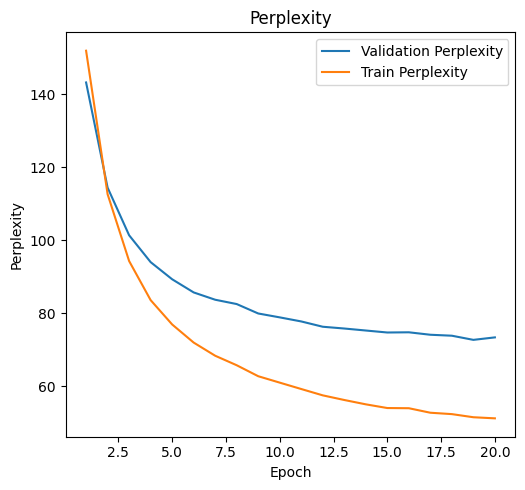

In [201]:
    # Plot learning curves
    plt.figure(figsize=(10, 5))

    # Plot Validation and Train Perplexity
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), val_ppls, label='Validation Perplexity')
    plt.plot(range(1, num_epochs + 1), train_ppls, label='Train Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Perplexity')
    plt.legend()

    plt.tight_layout()
    plt.show()